In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
file_path = '/content/drive/MyDrive/2025Fall_CS526_GroupProject/cleaned_data.csv'

try:
    # Read CSV file
    df = pd.read_csv(file_path)
    print("Successfully loaded data file!")
    print(f"File path: {file_path}")

except FileNotFoundError:
    print(f"File not found: {file_path}")
    print("Please confirm the file path is correct")
    raise
except Exception as e:
    print(f"Error reading file: {str(e)}")
    raise


Successfully loaded data file!
File path: /content/drive/MyDrive/2025Fall_CS526_GroupProject/cleaned_data.csv


In [21]:
# Prepare features and target
target = "readmit_label"
drop_cols = ["subject_id", "hadm_id", "admittime", "dischtime"]
X = df.drop(columns=drop_cols + [target])
y = df[target]

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["number"]).columns.tolist()

# Preprocessing
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols)
    ],
    sparse_threshold=1.0
)

# Fast L1-regularized logistic regression
model = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.1,
    max_iter=500,
    tol=1e-2,
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline([("pre", pre), ("lr", model)])
pipe.fit(X, y)

# Extract coefficients
ohe = pipe.named_steps["pre"].named_transformers_["cat"]
encoded_cat = ohe.get_feature_names_out(cat_cols)
feature_names = np.r_[num_cols, encoded_cat]

coef = pipe.named_steps["lr"].coef_.ravel()
nz = np.where(coef != 0)[0]

print(f"Selected features: {len(nz)} / {len(feature_names)}")
print("Top 10 features (by |coef|):")
top = np.argsort(-np.abs(coef[nz]))[:10]
for i in top:
    print(f"{feature_names[nz[i]]:35s}  coef={coef[nz[i]]:.4f}")


Selected features: 102 / 121
Top 10 features (by |coef|):
died_in_hospital                     coef=-0.6032
last_service_OMED                    coef=0.4505
gender_F                             coef=-0.3823
admission_type_SURGICAL SAME DAY ADMISSION  coef=-0.3403
discharge_location_HOSPICE           coef=-0.3182
last_service_ORTHO                   coef=-0.2996
days_since_prev_discharge            coef=-0.2812
gender_M                             coef=-0.2198
insurance_Private                    coef=-0.2107
admission_location_TRANSFER FROM HOSPITAL  coef=-0.2098


In [24]:

selected_features = pd.DataFrame({
    "feature_name": feature_names[nz],
    "coefficient": coef[nz]
}).sort_values(by="coefficient", key=np.abs, ascending=False)

# Save to Google Drive
output_path = "/content/drive/MyDrive/2025Fall_CS526_GroupProject/selected_features.csv"
selected_features.to_csv(output_path, index=False)

print(f"Exported {len(selected_features)} selected features to:")
print(output_path)

Exported 102 selected features to:
/content/drive/MyDrive/2025Fall_CS526_GroupProject/selected_features.csv


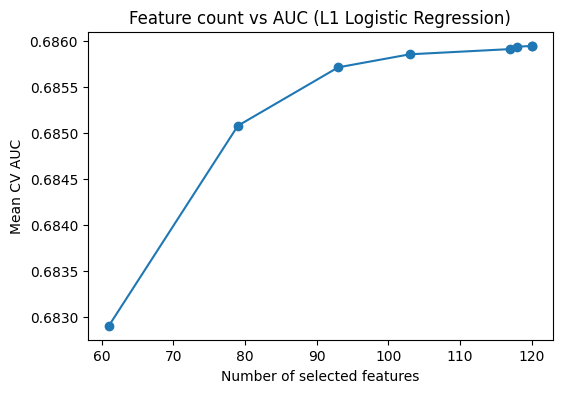

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

Cs = np.logspace(-2, 1, 8)  # 从 0.01 到 10
selected_counts = []
auc_scores = []

for C in Cs:
    lr = LogisticRegression(
        penalty='l1',
        solver='saga',
        C=C,
        max_iter=1000,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )
    pipe = Pipeline([("pre", pre), ("lr", lr)])
    auc = cross_val_score(pipe, X, y, cv=StratifiedKFold(3, shuffle=True, random_state=42),
                          scoring='roc_auc').mean()
    auc_scores.append(auc)

    pipe.fit(X, y)
    coef = pipe.named_steps["lr"].coef_.ravel()
    selected_counts.append(np.sum(coef != 0))

plt.figure(figsize=(6,4))
plt.plot(selected_counts, auc_scores, marker='o')
plt.xlabel("Number of selected features")
plt.ylabel("Mean CV AUC")
plt.title("Feature count vs AUC (L1 Logistic Regression)")
plt.show()
